Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pya

## Loading the Dataset

you can find the dataset info [here](https://huggingface.co/datasets/Helsinki-NLP/kde4)

another dataset to use you can find it [here](https://huggingface.co/datasets/Helsinki-NLP/opus-100) and this is the [src](https://opus.nlpl.eu/results/en&arz/corpus-result-table)

In [ ]:
from datasets import load_dataset

datasets = load_dataset("kde4", lang1="ar", lang2="en")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


kde4.py:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 116239
    })
})

In [ ]:
datasets["train"][11001]["translation"]

{'ar': 'الرجاء إدخال اسم المجموعة.', 'en': 'Please enter the new filter name.'}

### Text length distributions

In [ ]:
# Extract sentence lengths
ar_lengths = [len(row['translation']['ar']) for row in datasets['train']]
en_lengths = [len(row['translation']['en']) for row in datasets['train']]

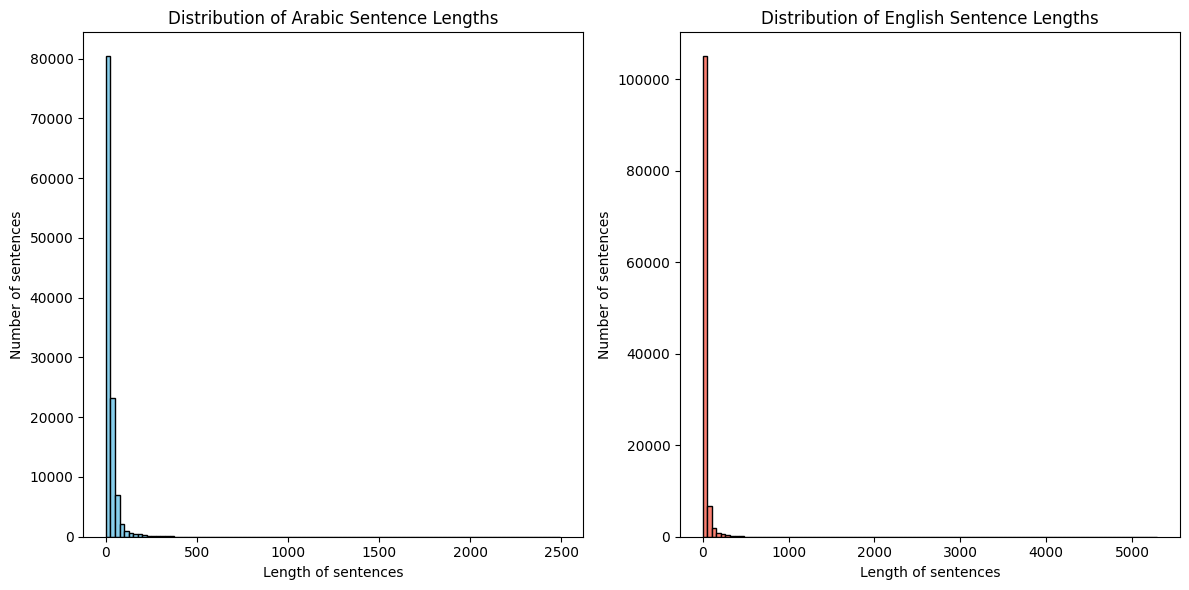

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for Arabic sentences
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(ar_lengths, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Arabic Sentence Lengths')
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')

# Histogram for English sentences
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(en_lengths, bins=100, color='salmon', edgecolor='black')
plt.title('Distribution of English Sentence Lengths')
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')

plt.tight_layout()
plt.show()

### Splitting the dataset

In [ ]:
# Shuffle the dataset
shuffled_dataset = datasets['train'].shuffle(seed=42)

In [ ]:
# Split the dataset into training, validation, and test sets
train_test_split = shuffled_dataset.train_test_split(test_size=0.2)
# Now split the test set into half validation and half test
test_valid_split = train_test_split['test'].train_test_split(test_size=0.5)

In [ ]:
# Assemble the final splits
final_splits = {
    'train': train_test_split['train'],
    'validation': test_valid_split['test'],
    'test': test_valid_split['train']
}

In [ ]:
from datasets import DatasetDict

split_datasets = DatasetDict({
    'train': final_splits['train'],
    'validation': final_splits['validation'],
    'test': final_splits['test']
})

In [ ]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 92991
    })
    validation: Dataset({
        features: ['id', 'translation'],
        num_rows: 11624
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 11624
    })
})

In [ ]:
split_datasets["train"][9011]["translation"]

{'ar': 'عمود قائمThe shape of the cursor', 'en': 'I-Beam'}

## Tokenization

you can find the model [here](https://huggingface.co/Helsinki-NLP/opus-mt-en-ar) which is produced by [the University of Helsinki](https://huggingface.co/Helsinki-NLP)

In [ ]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-ar"

translator = pipeline("translation", model=model_checkpoint)
translator("OpenAI company has released a new LLM model")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/917k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'translation_text': 'أصدرت شركة OpenAI نموذجاً جديداً لـ LLM'}]

In [ ]:
split_datasets["train"][3457]["translation"]

{'ar': 'استعمل عملية ssh- agent شغالة أو ابدأ واحدة جديدةNAME OF TRANSLATORS',
 'en': 'Utilize a running or start a new ssh-agent process'}

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-ar"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

In [ ]:
en_sentence = split_datasets["train"][3457]["translation"]["en"]
ar_sentence = split_datasets["train"][3457]["translation"]["ar"]

inputs = tokenizer(en_sentence, text_target=ar_sentence)
inputs

{'input_ids': [60834, 319, 15, 5914, 72, 2222, 15, 312, 140, 10283, 22, 228, 20249, 429, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [27966, 427, 140, 10283, 22, 79, 20195, 5316, 33194, 6603, 59, 31054, 1064, 963, 14011, 16621, 1963, 2640, 79, 26504, 12304, 378, 368, 182, 1894, 11715, 378, 0]}

In [ ]:
wrong_targets = tokenizer(ar_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))

['▁', 'ا', 'س', 'ت', 'ع', 'م', 'ل', '▁', 'ع', 'م', 'ل', 'ي', 'ة', '▁s', 'sh', '-', '▁agent', '▁', 'ش', 'غ', 'ا', 'ل', 'ة', '▁', 'أ', 'و', '▁', 'ا', 'ب', 'د', 'أ', '▁', 'و', 'ا', 'ح', 'د', 'ة', '▁', 'ج', 'د', 'ي', 'د', 'ة', 'NAM', 'E', '▁OF', '▁TRANS', 'LA', 'TOR', 'S', '</s>']
['▁استعمل', '▁عملية', '▁s', 'sh', '-', '▁', 'ag', 'ent', '▁شغ', 'الة', '▁أو', '▁ابدأ', '▁واحدة', '▁جديدة', 'NA', 'ME', '▁O', 'F', '▁', 'TR', 'AN', 'S', 'L', 'A', 'T', 'OR', 'S', '</s>']


In [ ]:
max_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["ar"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

Map:   0%|          | 0/92991 [00:00<?, ? examples/s]

Map:   0%|          | 0/11624 [00:00<?, ? examples/s]

Map:   0%|          | 0/11624 [00:00<?, ? examples/s]

## Model Defining

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
batch["labels"]

tensor([[33617,    17,    28,   141,  7266,  1878,  5703,   340, 12948,     0],
        [25100,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100]])

In [ ]:
batch["decoder_input_ids"]

tensor([[62801, 33617,    17,    28,   141,  7266,  1878,  5703,   340, 12948],
        [62801, 25100,     0, 62801, 62801, 62801, 62801, 62801, 62801, 62801]])

In [ ]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"])

[33617, 17, 28, 141, 7266, 1878, 5703, 340, 12948, 0]
[25100, 0]


## Evaluation Metric

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 46.750469682990165,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

In [ ]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 1.683602693167689,
 'counts': [1, 0, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'bp': 0.10539922456186433,
 'sys_len': 4,
 'ref_len': 13}

In [ ]:
predictions = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 0.0,
 'counts': [2, 1, 0, 0],
 'totals': [2, 1, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 0.004086771438464067,
 'sys_len': 2,
 'ref_len': 13}

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [2]:
model_path = '/content/drive/MyDrive/NER_Translation/translation_model'

In [ ]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    model_path+"/finetuned-translator-en-to-ar",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    disable_tqdm= False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


**Evaluate the model after fine-tuning**

In [ ]:
trainer.evaluate(max_length=max_length)

{'eval_loss': 5.303671360015869,
 'eval_model_preparation_time': 0.0043,
 'eval_bleu': 6.739082933148302,
 'eval_runtime': 961.7895,
 'eval_samples_per_second': 12.086,
 'eval_steps_per_second': 0.189}

### Start Training

In [ ]:
trainer.train()

Step,Training Loss
500,1.753300
1000,1.892000
1500,1.903900
2000,1.772300
2500,1.740000
3000,1.676300
3500,1.557700
4000,1.507600
4500,1.532400
5000,1.499200


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62801]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62801]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=8718, training_loss=1.565655310347037, metrics={'train_runtime': 1330.9424, 'train_samples_per_second': 209.606, 'train_steps_per_second': 6.55, 'total_flos': 3572456783413248.0, 'train_loss': 1.565655310347037, 'epoch': 3.0})

**Evaluate the model before fine-tuning**

In [ ]:
trainer.evaluate(max_length=max_length)

{'eval_loss': 1.4190373420715332,
 'eval_bleu': 27.443059908216718,
 'eval_runtime': 633.4993,
 'eval_samples_per_second': 18.349,
 'eval_steps_per_second': 0.287,
 'epoch': 3.0}

## Saving the model

In [ ]:
trainer.save_model(model_path + "/EN-AR_translator_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62801]], 'forced_eos_token_id': 0}


## Using the fine-tuned model

In [3]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = model_path + "/EN-AR_translator_model"

translator = pipeline("translation", model=model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
translator(
    " Donald Trump wanted to spend this week attacking one of Democratic rival Kamala Harris’ biggest political vulnerabilities. Instead, he spent most of the week falsely claiming that migrants are eating pets in a small town in Ohio and defending his embrace of a far-right agitator whose presence is causing concern among his allies."
)

[{'translation_text': 'دونالد ترامب أراد أن يقضي هذا الأسبوع في الهجوم على واحد من أكبر نقاط ضعف كمالا هاريس الحزبي. بدلاً من ذلك فقد أمضى أغلب الأسبوع يدّعي زوراً أن المهاجر يأكل حيوانات أليفة في بلدة صغيرة في أوهايو ويدافع عن اعتناقه لمهيج يميني مضلّع والذي يسبب وجوده قلقاً بين حليفيه.'}]